<a href="https://colab.research.google.com/github/micheldc55/Reinforced_Learning/blob/main/Copia_de_2_OIV_vs_greedy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Valores Iniciales Optimistas ("Optimistic Initial Values")**

- El agente puede tomar 3 acciones ("bandits"): 1, 2, 3
- El resultado de la acción i tiene un reward r_i
- El r_i sigue una distribución gaussiana con media m_i y desviación estándar std_i
- Los 6 parámetros (m_1, std_1, m_2, std_2, m3, std_3) son inicialmente desconocidos para el agente
- El agente tiene que tomar decisiones una y otra vez
- Su objetivo es maximizar su beneficio

In [ ]:
# Adaptado de:
#
# https://deeplearningcourses.com/c/artificial-intelligence-reinforcement-learning-in-python
# https://www.udemy.com/artificial-intelligence-reinforcement-learning-in-python

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm as gaussiana

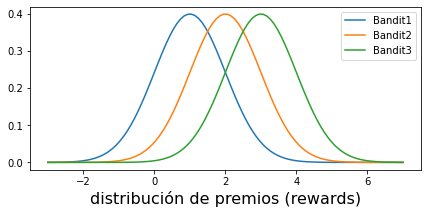

In [ ]:
m1   = 1. # medias y desviaciones estándar de los premios (rewards) que da cada bandit
std1 = 1.
m2   = 2
std2 = 1.
m3   = 3.
std3 = 1.

plt.figure(figsize=(7,3))
premios = np.linspace(-3,7,100)
plt.plot(premios, gaussiana.pdf(x=premios, loc=m1, scale=std1), label='Bandit1')
plt.plot(premios, gaussiana.pdf(x=premios, loc=m2, scale=std2), label='Bandit2')
plt.plot(premios, gaussiana.pdf(x=premios, loc=m3, scale=std3), label='Bandit3')
plt.xlabel('distribución de premios (rewards)', fontsize=16)
plt.legend();

In [ ]:
class Bandit:
    def __init__(self, mean, std=1, addseed=0): # se inicializa bandit
        self.mean = mean
        np.random.seed(1234567+int(str(mean).replace(".",""))+addseed)
        # se generan todas las futuras salidas de Bandit
        self.maxpulls = 1000000
        self.futurepulls = self.mean + std*np.random.randn(self.maxpulls)
        self.n = 0 # la primera salida
    
    def pull(self): # se acciona bandit
        aux = self.futurepulls[self.n]
        self.n = self.n + 1
        
        if self.n == self.maxpulls:
            self.n = 0
        
        # el if anterior es equivalente a:
        # self.n = (self.n + 1) % self.maxpulls
        return aux

In [ ]:
bandit1 = Bandit(m1, std1)

In [ ]:
N=10000
premios1 = [bandit1.pull() for _ in range(N)]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


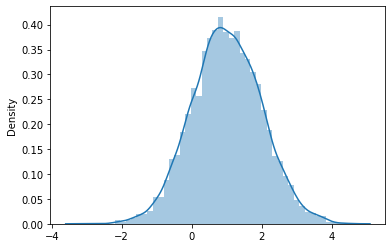

In [ ]:
sns.distplot(premios1);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

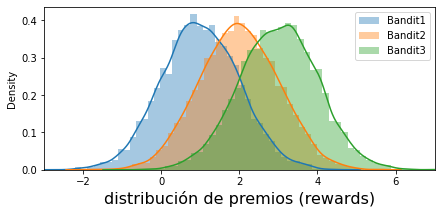

In [ ]:
bandit1 = Bandit(m1, std1)
bandit2 = Bandit(m2, std2)
bandit3 = Bandit(m3, std3)

premios1 = [bandit1.pull() for _ in range(N)]
premios2 = [bandit2.pull() for _ in range(N)]
premios3 = [bandit3.pull() for _ in range(N)]

plt.figure(figsize=(7,3))
sns.distplot(premios1, label='Bandit1')
sns.distplot(premios2, label='Bandit2')
sns.distplot(premios3, label='Bandit3')
plt.xlim(-3,7)
plt.xlabel('distribución de premios (rewards)', fontsize=16)
plt.legend();

In [ ]:
N = 100000

In [ ]:
class estimacion_Bandit:
    def __init__(self):
        # se inicializan todas las estimaciones a 0
        self.suma_premios = 0
        self.N = 0
        self.mean = 0
        
    def update(self, x):
        self.suma_premios += x
        self.N += 1
        self.mean = self.suma_premios / self.N

In [ ]:
## El OIV es inicializar con un valor optimista. Asumo que todas las máquinas van a dar muy buenos resultados. En la primera tirada, elijo una máquina al azar, porque todas dan
## el mismo resultado optimista. Una vez que elijo una, su desempeño típicamente va a ser peor al reward inicial que le doy. Entonces va a bajar el valor de la recompensa 
## esperada del modelo. Entonces en la próxima tirada, voy a elegir otra máquina distinta. Y así paso a paso me voy a ir acercando "por arriba" en lugar de por abajo.

class estimacion_Bandit_OIV: # optimistic initialization value
    def __init__(self, upper_limit):
        # se inicializan todas las estimaciones a 0
        self.suma_premios = upper_limit
        self.N = 1
        self.mean = upper_limit
        
    def update(self, x):
        self.suma_premios += x
        self.N += 1
        self.mean = self.suma_premios / self.N

In [ ]:
def run_experiment_egreedy(bandits, epsilon, N_total, vis=True):
    estimated_bandits = [estimacion_Bandit() for _ in bandits]
    
    rewards = np.empty(N)
    
    for i in range(N):
        # epsilon greedy
        p = np.random.random()
        if p < epsilon:
            j = np.random.choice(3)
        else:
            j = np.argmax([b.mean for b in estimated_bandits])
        
        x = bandits[j].pull()
        estimated_bandits[j].update(x)
        # para dibujar:
        rewards[i] = x
        
    cumulative_reward  = np.cumsum(rewards)
    cumulative_average = cumulative_reward / (np.arange(N) + 1)

    if vis:
        # plot moving average ctr
        plt.figure(figsize=(7,3))
        x = np.array(range(1,N+1))
        plt.plot(x, N*[bandits[0].mean], label='bandit 1 real mean')
        plt.plot(x, N*[bandits[1].mean], label='bandit 2 real mean')
        plt.plot(x, N*[bandits[2].mean], label='bandit 3 real mean')
        plt.plot(x, cumulative_average, label='average reward')
        plt.title('$\epsilon$-greedy, $\epsilon$={}'.format(epsilon), fontsize=16)
        plt.xscale('log')
        plt.legend(loc=4)
        plt.show()
    
        for i,b in enumerate(estimated_bandits):
            print('media estimada del bandit {}: {}'.format(i+1,np.round(b.mean,3)))
    
    return cumulative_reward, cumulative_average

In [ ]:
def run_experiment_OIV(bandits, N_total, upper_limit=10): # optimistic initialization values
    estimated_bandits = [estimacion_Bandit_OIV(upper_limit=upper_limit) for _ in bandits]
    
    rewards = np.empty(N)
    
    for i in range(N):
        # optimistic initial values
        j = np.argmax([b.mean for b in estimated_bandits])
        x = bandits[j].pull()
        estimated_bandits[j].update(x)
        
        # for the plot
        rewards[i] = x
    
    cumulative_reward = np.cumsum(rewards)
    cumulative_average = cumulative_reward / (np.arange(N) + 1)

    # plot moving average ctr
    plt.figure(figsize=(7,3))
    plt.plot(cumulative_average, label='average reward')
    plt.plot(N*[bandits[0].mean], label='bandit 1 real mean')
    plt.plot(N*[bandits[1].mean], label='bandit 2 real mean')
    plt.plot(N*[bandits[2].mean], label='bandit 3 real mean')
    plt.title('OIV, upper limit={}'.format(upper_limit), fontsize=16)
    plt.xscale('log')
    plt.legend()
    plt.show()
    
    for i,b in enumerate(estimated_bandits):
        print('media estimada del bandit {}: {} ({} pulls)'.format(i+1,np.round(b.mean,3),b.N-1))
    
    return cumulative_reward, cumulative_average

**Experimento epsilon-greedy**

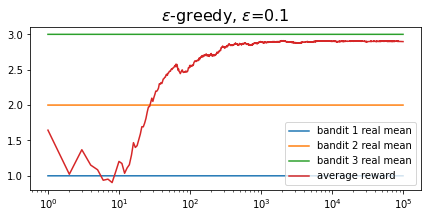

media estimada del bandit 1: 1.003
media estimada del bandit 2: 1.984
media estimada del bandit 3: 2.999






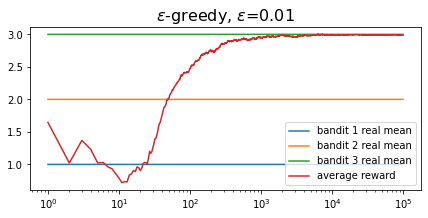

media estimada del bandit 1: 1.018
media estimada del bandit 2: 1.923
media estimada del bandit 3: 2.998






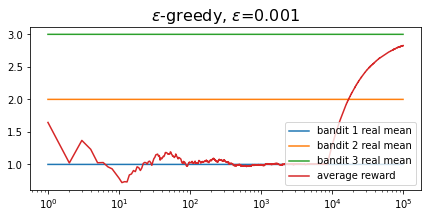

media estimada del bandit 1: 1.004
media estimada del bandit 2: 1.66
media estimada del bandit 3: 2.999






In [ ]:
epsilons = [1e-1, 1e-2, 1e-3]

total_rewards_EG = []
average_rewards_EG = []
for e in epsilons:
    bandit1 = Bandit(m1, std1)
    bandit2 = Bandit(m2, std2)
    bandit3 = Bandit(m3, std3)

    total_reward_EG, average_reward_EG  = run_experiment_egreedy([bandit1, bandit2, bandit3],
                                                                 epsilon=e, N_total=N)
    total_rewards_EG.append(total_reward_EG)
    average_rewards_EG.append(average_reward_EG)
    print("\n\n\n")

**Experimento OIV:**

In [ ]:
m1, m2, m3

(1.0, 2, 3.0)

In [ ]:
std1, std2, std3

(1.0, 1.0, 1.0)

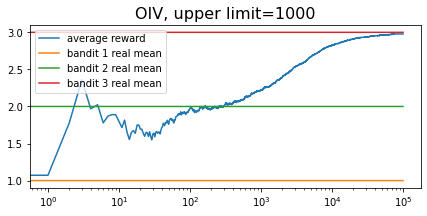

media estimada del bandit 1: 3.005 (497 pulls)
media estimada del bandit 2: 3.007 (977 pulls)
media estimada del bandit 3: 3.008 (98526 pulls)


In [ ]:
bandit1 = Bandit(m1, std1)
bandit2 = Bandit(m2, std2)
bandit3 = Bandit(m3, std3)

total_reward_OIV, average_reward_OIV  = run_experiment_OIV([bandit1, bandit2, bandit3], N_total=N, upper_limit=1000)

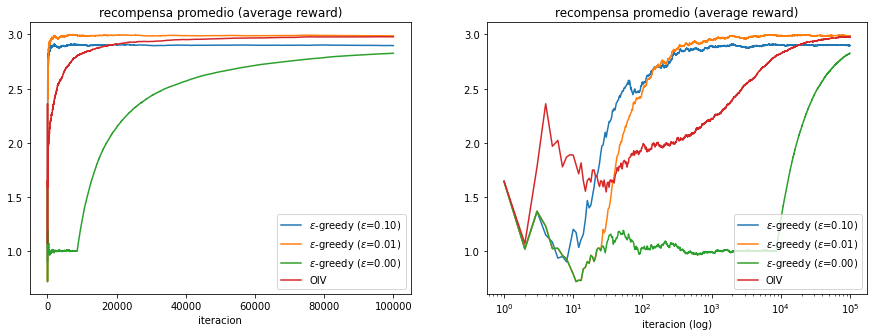

In [ ]:
plt.figure(figsize=(15,5))

# linear plot
x = np.array(range(1,N+1))
plt.subplot(1,2,1)
for average_reward_EG, e in zip(average_rewards_EG, epsilons):
    plt.plot(x, average_reward_EG, label='$\epsilon$-greedy ($\epsilon$=%.2f)' % e)
plt.plot(x, average_reward_OIV, label='OIV')
plt.legend(loc=4)
plt.xlabel('iteracion')
plt.title('recompensa promedio (average reward)')

# log scale plot
plt.subplot(1,2,2)
for average_reward_EG, e in zip(average_rewards_EG, epsilons):
    plt.plot(x, average_reward_EG, label='$\epsilon$-greedy ($\epsilon$=%.2f)' % e)
plt.plot(x, average_reward_OIV, label='OIV')
plt.legend(loc=4)
plt.xscale('log')
plt.xlabel('iteracion (log)')
plt.title('recompensa promedio (average reward)');

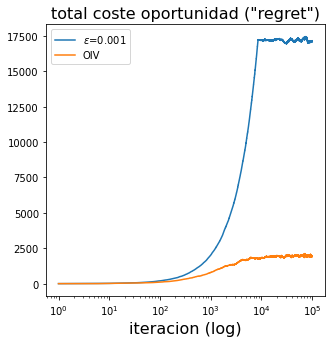

In [ ]:
plt.figure(figsize=(5,5))
max_m = max([m1,m2,m3])
optimal_bandit = Bandit(max_m)
optimal_gains = [optimal_bandit.pull() for _ in range(N)]

plt.plot(x, np.cumsum(optimal_gains) - total_reward_EG,  label='$\epsilon$={}'.format(e))
plt.plot(x, np.cumsum(optimal_gains) - total_reward_OIV, label='OIV')
plt.legend(loc=0)
plt.xscale('log')
plt.xlabel('iteracion (log)', fontsize=16)
plt.title('total coste oportunidad ("regret")', fontsize=16);